In [1]:
using HTTP
using JSON
using DataFrames
using Dates
using TimeSeries

In [2]:
include("../env.jl")

"VVp9vMTjNvSEUqJJuqpRLw5r4oUq2uFGbX2VipCE"

In [3]:
function wgetStock(sym::String)
    fromTime =  Dates.format(now()-Day(500), "yyyy-mm-ddTHH:MM:SS")
    @show fromTime
    headers = ["APCA-API-KEY-ID" => ENV["APCA-API-KEY-ID"], "APCA-API-SECRET-KEY" => ENV["APCA-API-SECRET-KEY"] ]
    url_query = "https://data.alpaca.markets/v1/bars/day?symbols="*sym*"&after="*fromTime*"&limit=500"
    raw_response = HTTP.request("GET", url_query, headers)
    rsp = JSON.parse(String(raw_response.body))
    df2 = DataFrame(t = Int[],h = Float32[],l = Float32[],o = Float32[],c = Float32[],v = Float32[] )
    for (sym,v) in rsp
        for q in v
            push!(df2,q)
        end
    end
    transform!(df2, :t => ( x -> Dates.unix2datetime.(x) ) => :ondate)
    DataFrames.rename!(df2,:h => :High)
    DataFrames.rename!(df2,:l => :Low)
    DataFrames.rename!(df2,:o => :Open)
    DataFrames.rename!(df2,:c => :Close)
    DataFrames.rename!(df2,:v => :Volume)
    sort!(df2,order(:ondate))
    return select(df2,[:Open,:Close,:High,:Low,:Volume,:ondate])
end

wgetStock (generic function with 1 method)

In [4]:
tick1="GLD"
df1 = wgetStock(tick1)
tick2="IAU"
df2 = wgetStock(tick2)

fromTime = "2020-02-03T22:25:50"
fromTime = "2020-02-03T22:25:55"


,Open,Close,High,Low,Volume,ondate
,Float32,Float32,Float32,Float32,Float32,DateTime
1,13.69,13.61,13.75,12.86,5.52916e7,2019-06-25T04:00:00
2,13.5,13.48,13.55,13.43,1.58035e7,2019-06-26T04:00:00
3,13.43,13.48,13.49,13.41,1.53106e7,2019-06-27T04:00:00
4,13.49,13.505,13.53,13.45,8.48827e6,2019-06-28T04:00:00
5,13.35,13.25,13.36,13.24,2.35873e7,2019-07-01T04:00:00
6,13.32,13.53,13.55,13.3,2.23973e7,2019-07-02T04:00:00
7,13.55,13.56,13.6,13.51,1.96778e7,2019-07-03T04:00:00
8,13.33,13.4,13.42,13.27,2.15812e7,2019-07-05T04:00:00
9,13.41,13.32,13.43,13.32,2.00556e7,2019-07-08T04:00:00


In [5]:
using Pkg 
Pkg.add("StatsBase")
using StatsBase
Pkg.add("HypothesisTests")
using HypothesisTests

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [6]:

using Plots
function testStationary(df)
    y = autocor(df,1:20)
    display(bar(y))
    y = pacf(df,1:20)
    display(bar(y))
    ADFTest(df,:none,1)
end

testStationary (generic function with 1 method)

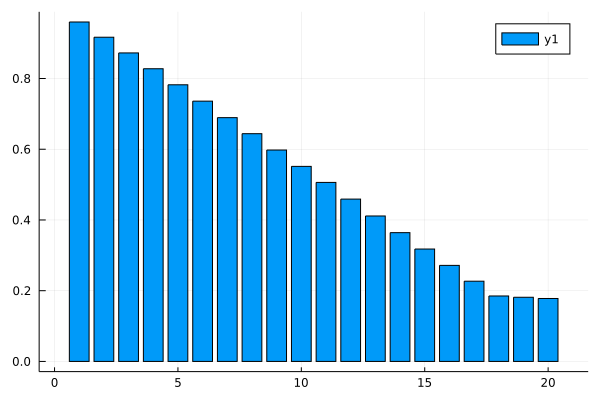

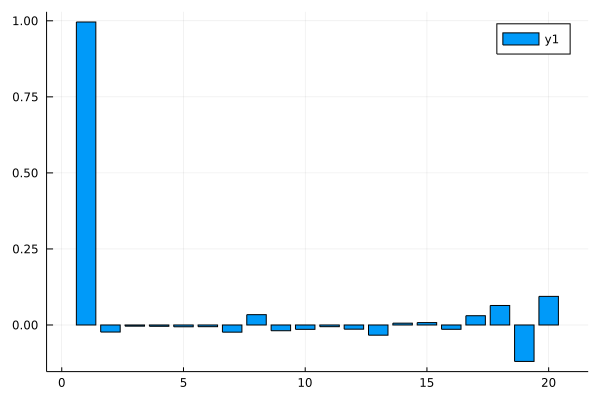

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.002027

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9077

Details:
    sample size in regression:          498
    number of lags:                     1
    ADF statistic:                      0.942515
    Critical values at 1%, 5%, and 10%: [-2.57023 -1.94155 -1.6163]


In [38]:
testStationary(df2[!,:Close])

In [8]:
Pkg.add("TimeSeries")
using TimeSeries

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [9]:
ta1 = TimeArray(df1;timestamp = :ondate)
ta2 = TimeArray(df2;timestamp = :ondate)
merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])

500×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-25T04:00:00 to 2021-06-17T04:00:00
│                     │ Close1  │ Close2  │
├─────────────────────┼─────────┼─────────┤
│ 2019-06-25T04:00:00 │ 134.2   │ 13.61   │
│ 2019-06-26T04:00:00 │ 132.97  │ 13.48   │
│ 2019-06-27T04:00:00 │ 132.84  │ 13.48   │
│ 2019-06-28T04:00:00 │ 133.17  │ 13.505  │
│ 2019-07-01T04:00:00 │ 130.6   │ 13.25   │
│ 2019-07-02T04:00:00 │ 133.38  │ 13.53   │
│ 2019-07-03T04:00:00 │ 133.64  │ 13.56   │
│ 2019-07-05T04:00:00 │ 132.16  │ 13.4    │
│ 2019-07-08T04:00:00 │ 131.29  │ 13.32   │
│ 2019-07-09T04:00:00 │ 131.78  │ 13.365  │
│ 2019-07-10T04:00:00 │ 133.82  │ 13.57   │
│ 2019-07-11T04:00:00 │ 132.7   │ 13.47   │
   ⋮
│ 2021-06-03T04:00:00 │ 175.25  │ 35.645  │
│ 2021-06-04T04:00:00 │ 177.17  │ 36.04   │
│ 2021-06-07T04:00:00 │ 177.88  │ 36.185  │
│ 2021-06-08T04:00:00 │ 177.3   │ 36.07   │
│ 2021-06-09T04:00:00 │ 176.97  │ 36.0    │
│ 2021-06-10T04:00:00 │ 177.73  │ 36.16   │
│ 2021-06-11T04:0

In [10]:
pct1 = percentchange(ta1[:Close])
pct2 = percentchange(ta2[:Close])
pct = merge(pct1,pct2)
TimeSeries.rename!(pct,:Close => :Close1)
TimeSeries.rename!(pct,:Close_1 => :Close2)
dif = TimeSeries.rename(pct[:Close1] .- pct[:Close2], :Close1_Close2 => :Diff) 
data = merge(pct,dif)
df = DataFrame(data[3:9])
current = DataFrame(data[10])
@show df[3,:Close1]
@show size(current)
current[1,:Close1]

df[3, :Close1] = 0.021286238f0
size(current) = (1, 4)


0.015480384f0

mean(df[!, :Diff]) = -7.532966f-6
std(df[!, :Diff]) = 0.0004490483f0


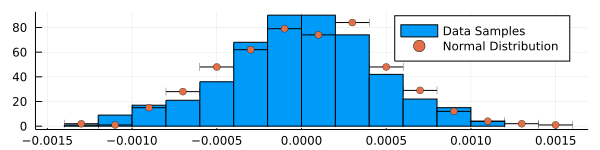

In [11]:
using Random, Distributions
using StatsBase
df = DataFrame(data)

lower = quantile(df[:,:Diff], 0.01)
upper = quantile(df[:,:Diff], 0.99)
df = filter(:Diff => x -> x > lower, df)
df = filter(:Diff => x -> x < upper, df)
@show mean(df[!,:Diff])
@show std(df[!,:Diff])
histogram(df[!,:Diff], labels="Data Samples")
d=fit(Normal, df[!,:Diff])
n = length(df[:,:Diff])
plot!(rand(d, n), seriestype=:scatterhist, linestyle=:solid, size=(600,150),labels="Normal Distribution")


In [12]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

mean(rand(d, 10000)) = -6.783364608213885e-6
std(rand(d, 10000)) = 0.00044911895442590775


0.00044911895442590775

In [13]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

mean(rand(d, 10000)) = -8.09977108291575e-6
std(rand(d, 10000)) = 0.0004481302097770603


0.0004481302097770603

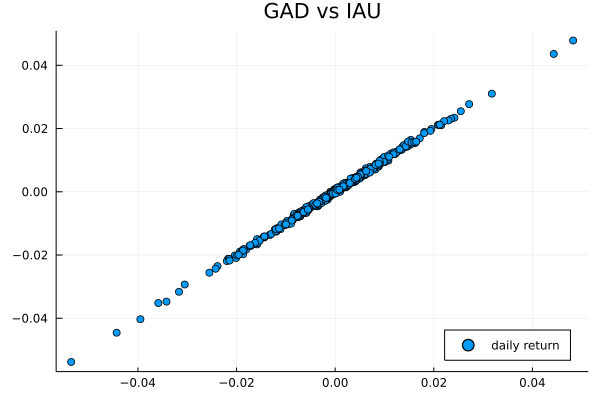

In [14]:
x = df[!,:Close1]
y = df[!,:Close2]
plot(x, y, seriestype = :scatter, title = "GAD vs IAU", label = "daily return",legend=:bottomright)

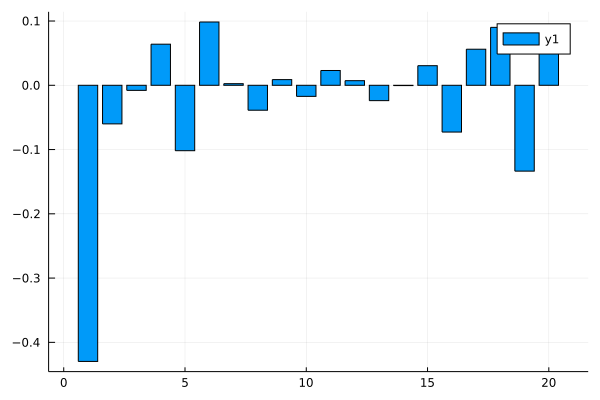

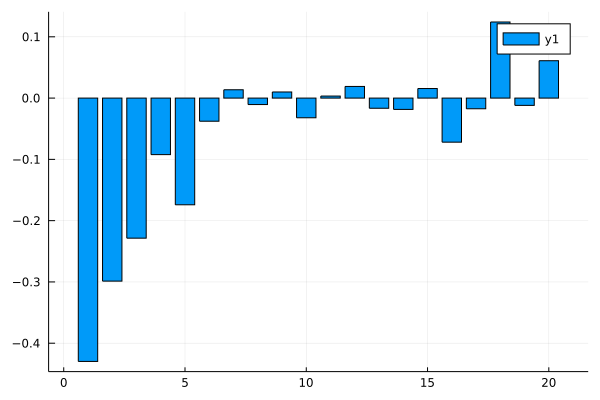

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.85186

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          487
    number of lags:                     1
    ADF statistic:                      -25.3838
    Critical values at 1%, 5%, and 10%: [-2.57033 -1.94156 -1.61629]


In [41]:
testStationary(df[!,:Diff])

In [16]:
# Import Turing and Distributions.
using Turing, Distributions



# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

# Functionality for splitting and normalizing the data
using MLDataUtils: rescale!

# Set a seed for reproducibility.
using Random
Random.seed!(0);

In [17]:
# Bayesian logistic regression (LR)
@model linearPair(y0,y1,n) = begin
    u ~ Normal(1,0.1)
    for i = 1:n
        y1[i] ~ Normal( u*y0[i],0.1)
    end
end;

In [18]:

n,_ = size(df)
@show n
train = Matrix(df)


n = 489


489×4 Matrix{Any}:
 2019-06-26T04:00:00  -0.00916546   -0.00955187    0.000386403
 2019-06-27T04:00:00  -0.000977515   0.0          -0.000977515
 2019-06-28T04:00:00   0.00248406    0.00185471    0.000629357
 2019-07-01T04:00:00  -0.0192983    -0.018882     -0.000416283
 2019-07-02T04:00:00   0.0212862     0.0211321     0.000154119
 2019-07-03T04:00:00   0.0019493     0.00221736   -0.000268063
 2019-07-05T04:00:00  -0.0110747    -0.0117995     0.000724752
 2019-07-08T04:00:00  -0.00658291   -0.00597023   -0.000612681
 2019-07-09T04:00:00   0.00373248    0.0033786     0.000353875
 2019-07-10T04:00:00   0.0154804     0.0153385     0.000141866
 2019-07-11T04:00:00  -0.00836951   -0.00736917   -0.00100034
 2019-07-12T04:00:00   0.00602863    0.00556797    0.000460658
 2019-07-15T04:00:00   7.48662f-5   -0.000369242   0.000444108
 ⋮                                                            
 2021-06-02T04:00:00   0.00460825    0.00469616   -8.79066f-5
 2021-06-03T04:00:00  -0.0195802    -0

In [19]:



# Sample using HMC.
chain = mapreduce(c -> sample(linearPair(train[:,2],train[:,3],n),NUTS(200, 0.65), 1000, discard_adapt=true),
    chainscat,
    1:5
)

describe(chain)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|███████

2-element Vector{ChainDataFrame}:
 Summary Statistics (1 x 8)
 Quantiles (1 x 6)

In [20]:
#plot(chain)

In [21]:
chain

Chains MCMC chain (1000×13×5 Array{Float64, 3}):

Start time        = 2021-06-17T14:28:29.071
Stop time         = 2021-06-17T14:28:39.620
Wall duration     = 10.55 seconds
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5
Samples per chain = 1000
parameters        = u
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           u    1.0039    0.0968     0.0014    0.0020   2498.2301    1.0021    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         

In [22]:
lookback = 12
for (row_index,row) in enumerate(eachrow(pct))
    @show row.timestamp
    @show row.Close1
    @show row.Close2
    @show row_index
    if row_index >= lookback
        i = row_index
        @show size(pct[i-lookback+1:i])
        @show pct[i-lookback+1:i]
        @show values(mean(pct[i-lookback+1:i]))
        
    end
    
end

row.timestamp = DateTime("2019-06-26T04:00:00")
row.Close1 = -0.009165464f0
row.Close2 = -0.009551867f0
row_index = 1
row.timestamp = DateTime("2019-06-27T04:00:00")
row.Close1 = -0.0009775149f0
row.Close2 = 0.0f0
row_index = 2
row.timestamp = DateTime("2019-06-28T04:00:00")
row.Close1 = 0.0024840639f0
row.Close2 = 0.001854707f0
row_index = 3
row.timestamp = DateTime("2019-07-01T04:00:00")
row.Close1 = -0.019298261f0
row.Close2 = -0.018881978f0
row_index = 4
row.timestamp = DateTime("2019-07-02T04:00:00")
row.Close1 = 0.021286238f0
row.Close2 = 0.021132119f0
row_index = 5
row.timestamp = DateTime("2019-07-03T04:00:00")
row.Close1 = 0.0019493004f0
row.Close2 = 0.0022173633f0
row_index = 6
row.timestamp = DateTime("2019-07-05T04:00:00")
row.Close1 = -0.01107475f0
row.Close2 = -0.011799502f0
row_index = 7
row.timestamp = DateTime("2019-07-08T04:00:00")
row.Close1 = -0.006582909f0
row.Close2 = -0.005970228f0
row_index = 8
row.timestamp = DateTime("2019-07-09T04:00:00")
row.Close1 = 0.00373

values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0023883863 0.0023558792]
row.timestamp = DateTime("2019-08-22T04:00:00")
row.Close1 = -0.0025392664f0
row.Close2 = -0.0020877947f0
row_index = 41
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-07T04:00:00 to 2019-08-22T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0015055662 0.0014961405]
row.timestamp = DateTime("2019-08-23T04:00:00")
row.Close1 = 0.019519031f0
row.Close2 = 0.019874465f0
row_index = 42
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-08T04:00:00 to 2019-08-23T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0018604783 0.0019103386]
row.timestamp = DateTime("2019-08-26T04:00:00")
row.Close1 = 0.00020792261f0
row.Close2 = -0.0003418338f0
row_index = 43
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 T

row.Close1 = 0.011818079f0
row.Close2 = 0.011997092f0
row_index = 69
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-17T04:00:00 to 2019-10-02T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[2.6224801f-5 0.000104618804]
row.timestamp = DateTime("2019-10-03T04:00:00")
row.Close1 = 0.0045301695f0
row.Close2 = 0.004184154f0
row_index = 70
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-18T04:00:00 to 2019-10-03T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00020912138 0.00022067502]
row.timestamp = DateTime("2019-10-04T04:00:00")
row.Close1 = 0.00014067686f0
row.Close2 = 0.0f0
row_index = 71
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-19T04:00:00 to 2019-10-04T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = F

row.Close1 = -0.0025473519f0
row.Close2 = -0.0028673946f0
row_index = 97
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-25T04:00:00 to 2019-11-11T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0026654403 -0.0026197482]
row.timestamp = DateTime("2019-11-12T05:00:00")
row.Close1 = 0.0029186797f0
row.Close2 = 0.00287564f0
row_index = 98
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-28T04:00:00 to 2019-11-12T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.002610621 -0.0026122367]
row.timestamp = DateTime("2019-11-13T05:00:00")
row.Close1 = 0.003929208f0
row.Close2 = 0.003584356f0
row_index = 99
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-29T04:00:00 to 2019-11-13T05:00:00
values(mean(pct[(i - lookback) + 1:

values(mean(pct[(i - lookback) + 1:i])) = Float32[0.004917549 0.004925084]
row.timestamp = DateTime("2020-01-07T05:00:00")
row.Close1 = 0.0040019746f0
row.Close2 = 0.0043433784f0
row_index = 135
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-12-19T05:00:00 to 2020-01-07T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0052570463 0.0053165704]
row.timestamp = DateTime("2020-01-08T05:00:00")
row.Close1 = -0.0077021f0
row.Close2 = -0.007984066f0
row_index = 136
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-12-20T05:00:00 to 2020-01-08T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.004417361 0.00450352]
row.timestamp = DateTime("2020-01-09T05:00:00")
row.Close1 = -0.0058555156f0
row.Close2 = -0.006706773f0
row_index = 137
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeAr

values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00030101094 0.00037466738]
row.timestamp = DateTime("2020-02-18T05:00:00")
row.Close1 = 0.0127535425f0
row.Close2 = 0.012892633f0
row_index = 163
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-31T05:00:00 to 2020-02-18T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0013750507 0.001393722]
row.timestamp = DateTime("2020-02-19T05:00:00")
row.Close1 = 0.006230131f0
row.Close2 = 0.005874656f0
row_index = 164
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-02-03T05:00:00 to 2020-02-19T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0013777696 0.0013856078]
row.timestamp = DateTime("2020-02-20T05:00:00")
row.Close1 = 0.0040177736f0
row.Close2 = 0.0038935447f0
row_index = 165
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 Ti

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-19T04:00:00 to 2020-04-03T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0071217506 0.007145773]
row.timestamp = DateTime("2020-04-06T04:00:00")
row.Close1 = 0.027170347f0
row.Close2 = 0.027724206f0
row_index = 197
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-20T04:00:00 to 2020-04-06T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.010937803 0.010973404]
row.timestamp = DateTime("2020-04-07T04:00:00")
row.Close1 = -0.0053538494f0
row.Close2 = -0.0050189486f0
row_index = 198
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-23T04:00:00 to 2020-04-07T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.009272485 0.009366368]
row.timestamp = DateTime("2020-04-08T04:00:00")
row.Close1 = -0.008971734f0

values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0011836916 0.0012117577]
row.timestamp = DateTime("2020-05-15T04:00:00")
row.Close1 = 0.005521225f0
row.Close2 = 0.006038706f0
row_index = 225
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-04-30T04:00:00 to 2020-05-15T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0011644306 0.0012046614]
row.timestamp = DateTime("2020-05-18T04:00:00")
row.Close1 = -0.0073821894f0
row.Close2 = -0.0075031146f0
row_index = 226
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-05-01T04:00:00 to 2020-05-18T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0021285943 0.0021517307]
row.timestamp = DateTime("2020-05-19T04:00:00")
row.Close1 = 0.009711388f0
row.Close2 = 0.009374176f0
row_index = 227
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 Ti

values(mean(pct[(i - lookback) + 1:i])) = Float32[0.003223174 0.003254764]
row.timestamp = DateTime("2020-06-25T04:00:00")
row.Close1 = -0.0008436457f0
row.Close2 = -0.0011863818f0
row_index = 253
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-10T04:00:00 to 2020-06-25T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0023649302 0.0023852454]
row.timestamp = DateTime("2020-06-26T04:00:00")
row.Close1 = 0.0044631124f0
row.Close2 = 0.0047507724f0
row_index = 254
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-11T04:00:00 to 2020-06-26T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0015220866 0.0015593987]
row.timestamp = DateTime("2020-06-29T04:00:00")
row.Close1 = 0.00048029033f0
row.Close2 = 0.0005909758f0
row_index = 255
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-07-31T04:00:00 to 2020-08-17T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0014258862 0.0014530563]
row.timestamp = DateTime("2020-08-18T04:00:00")
row.Close1 = 0.009385487f0
row.Close2 = 0.009767721f0
row_index = 290
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-03T04:00:00 to 2020-08-18T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0014325437 0.0014185217]
row.timestamp = DateTime("2020-08-19T04:00:00")
row.Close1 = -0.031666648f0
row.Close2 = -0.031634096f0
row_index = 291
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-04T04:00:00 to 2020-08-19T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0012961962 -0.0012618714]
row.timestamp = DateTime("2020-08-20T04:00:00")
row.Close1 = 0.0064743

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-09-10T04:00:00 to 2020-09-25T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0037195564 -0.0037605779]
row.timestamp = DateTime("2020-09-28T04:00:00")
row.Close1 = 0.009946371f0
row.Close2 = 0.010129388f0
row_index = 318
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-09-11T04:00:00 to 2020-09-28T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0026174763 -0.0026028575]
row.timestamp = DateTime("2020-09-29T04:00:00")
row.Close1 = 0.008659928f0
row.Close2 = 0.00891367f0
row_index = 319
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-09-14T04:00:00 to 2020-09-29T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0018958155 -0.0019050256]
row.timestamp = DateTime("2020-09-30T04:00:00")
row.Close1 = -0.00594

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-20T04:00:00 to 2020-11-04T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00022678329 0.00020963314]
row.timestamp = DateTime("2020-11-05T05:00:00")
row.Close1 = 0.022985287f0
row.Close2 = 0.022552215f0
row_index = 346
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-21T04:00:00 to 2020-11-05T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0017358052 0.0017444347]
row.timestamp = DateTime("2020-11-06T05:00:00")
row.Close1 = 0.0015857859f0
row.Close2 = 0.0016137256f0
row_index = 347
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-22T04:00:00 to 2020-11-06T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0012170858 0.0012384149]
row.timestamp = DateTime("2020-11-09T05:00:00")
row.Close1 = -0.044321

row.Close1 = -0.0032324886f0
row.Close2 = -0.0036261934f0
row_index = 381
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-10T05:00:00 to 2020-12-28T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.001598529 0.0015753213]
row.timestamp = DateTime("2020-12-29T05:00:00")
row.Close1 = 0.0032999006f0
row.Close2 = 0.0036393905f0
row_index = 382
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-11T05:00:00 to 2020-12-29T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0020015722 0.0019736786]
row.timestamp = DateTime("2020-12-30T05:00:00")
row.Close1 = 0.0077128694f0
row.Close2 = 0.0072524007f0
row_index = 383
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-14T05:00:00 to 2020-12-30T05:00:00
values(mean(pct[(i - lookback) +

row.Close1 = 0.00995215f0
row.Close2 = 0.011014599f0
row_index = 409
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-22T05:00:00 to 2021-02-08T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0017656876 -0.0017070478]
row.timestamp = DateTime("2021-02-09T05:00:00")
row.Close1 = 0.0034984606f0
row.Close2 = 0.0033714257f0
row_index = 410
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-25T05:00:00 to 2021-02-09T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.00082272635 -0.00081783556]
row.timestamp = DateTime("2021-02-10T05:00:00")
row.Close1 = 0.003719076f0
row.Close2 = 0.0034972643f0
row_index = 411
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-26T05:00:00 to 2021-02-10T05:00:00
values(mean(pct[(i - lookback) 

row.Close2 = 0.0036274262f0
row_index = 437
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-03-04T05:00:00 to 2021-03-19T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0013918463 0.0013498134]
row.timestamp = DateTime("2021-03-22T04:00:00")
row.Close1 = -0.0015923207f0
row.Close2 = -0.0015059088f0
row_index = 438
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-03-05T05:00:00 to 2021-03-22T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0020840247 0.0021423046]
row.timestamp = DateTime("2021-03-23T04:00:00")
row.Close1 = -0.0073003024f0
row.Close2 = -0.007541448f0
row_index = 439
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-03-08T05:00:00 to 2021-03-23T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.001433

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-28T04:00:00 to 2021-05-13T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0023623873 0.0023634515]
row.timestamp = DateTime("2021-05-14T04:00:00")
row.Close1 = 0.008998586f0
row.Close2 = 0.009770129f0
row_index = 476
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-29T04:00:00 to 2021-05-14T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0028568904 0.002882123]
row.timestamp = DateTime("2021-05-17T04:00:00")
row.Close1 = 0.0118137365f0
row.Close2 = 0.01186681f0
row_index = 477
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-30T04:00:00 to 2021-05-17T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0041758716 0.00421457]
row.timestamp = DateTime("2021-05-18T04:00:00")
row.Close1 = 0.0016598157f0
r

In [23]:
N = length(pct)
mean1,mean2 = values(mean(pct[1:lookback-1]))
@show mean1
@show mean2
std1,std2 = values(std(pct[1:lookback-1]))
@show std1
@show std2
function betafunc(x1,x2,beta)
    return x1 + beta*x2
end
std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1]
bf12 = betafunc.(pct[1:lookback-1,:Close1] , pct[1:lookback-1,:Close2],-1)
@show bf12
@show std12
currentprice = values(pct[12,:Close1])
@show currentprice
bf12

mean1 = -0.0009578133f0
mean2 = -0.0008774034f0
std1 = 0.011832049f0
std2 = 0.011705058f0
bf12 = 11×1 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-26T04:00:00 to 2019-07-11T04:00:00
std12 = 0.0006119954f0
currentprice = Float32[0.0060286317]


11×1 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-26T04:00:00 to 2019-07-11T04:00:00
│                     │ Close1_Close2 │
├─────────────────────┼───────────────┤
│ 2019-06-26T04:00:00 │ 0.0004        │
│ 2019-06-27T04:00:00 │ -0.001        │
│ 2019-06-28T04:00:00 │ 0.0006        │
│ 2019-07-01T04:00:00 │ -0.0004       │
│ 2019-07-02T04:00:00 │ 0.0002        │
│ 2019-07-03T04:00:00 │ -0.0003       │
│ 2019-07-05T04:00:00 │ 0.0007        │
│ 2019-07-08T04:00:00 │ -0.0006       │
│ 2019-07-09T04:00:00 │ 0.0004        │
│ 2019-07-10T04:00:00 │ 0.0001        │
│ 2019-07-11T04:00:00 │ -0.001        │

In [24]:
for i in 2:N
    @show values(pct[i-1:i,:Close1])
end

values(pct[i - 1:i, :Close1]) = Float32[-0.009165464; -0.0009775149]
values(pct[i - 1:i, :Close1]) = Float32[-0.0009775149; 0.0024840639]
values(pct[i - 1:i, :Close1]) = Float32[0.0024840639; -0.019298261]
values(pct[i - 1:i, :Close1]) = Float32[-0.019298261; 0.021286238]
values(pct[i - 1:i, :Close1]) = Float32[0.021286238; 0.0019493004]
values(pct[i - 1:i, :Close1]) = Float32[0.0019493004; -0.01107475]
values(pct[i - 1:i, :Close1]) = Float32[-0.01107475; -0.006582909]
values(pct[i - 1:i, :Close1]) = Float32[-0.006582909; 0.003732477]
values(pct[i - 1:i, :Close1]) = Float32[0.003732477; 0.015480384]
values(pct[i - 1:i, :Close1]) = Float32[0.015480384; -0.008369511]
values(pct[i - 1:i, :Close1]) = Float32[-0.008369511; 0.0060286317]
values(pct[i - 1:i, :Close1]) = Float32[0.0060286317; 7.4866235f-5]
values(pct[i - 1:i, :Close1]) = Float32[7.4866235f-5; -0.008426251]
values(pct[i - 1:i, :Close1]) = Float32[-0.008426251; 0.016655779]
values(pct[i - 1:i, :Close1]) = Float32[0.016655779; 0.

values(pct[i - 1:i, :Close1]) = Float32[0.0061975047; -0.006694695]
values(pct[i - 1:i, :Close1]) = Float32[-0.006694695; -0.013210006]
values(pct[i - 1:i, :Close1]) = Float32[-0.013210006; 0.0010925535]
values(pct[i - 1:i, :Close1]) = Float32[0.0010925535; 0.0057312544]
values(pct[i - 1:i, :Close1]) = Float32[0.0057312544; 0.0024419988]
values(pct[i - 1:i, :Close1]) = Float32[0.0024419988; 0.0025715458]
values(pct[i - 1:i, :Close1]) = Float32[0.0025715458; -0.0032400931]
values(pct[i - 1:i, :Close1]) = Float32[-0.0032400931; -0.0009479795]
values(pct[i - 1:i, :Close1]) = Float32[-0.0009479795; 0.0056938487]
values(pct[i - 1:i, :Close1]) = Float32[0.0056938487; 0.0041111344]
values(pct[i - 1:i, :Close1]) = Float32[0.0041111344; 0.0127535425]
values(pct[i - 1:i, :Close1]) = Float32[0.0127535425; 0.006230131]
values(pct[i - 1:i, :Close1]) = Float32[0.006230131; 0.0040177736]
values(pct[i - 1:i, :Close1]) = Float32[0.0040177736; 0.014695286]
values(pct[i - 1:i, :Close1]) = Float32[0.01469

values(pct[i - 1:i, :Close1]) = Float32[0.009375861; -0.0032785912]
values(pct[i - 1:i, :Close1]) = Float32[-0.0032785912; 0.0]
values(pct[i - 1:i, :Close1]) = Float32[0.0; 0.00789404]
values(pct[i - 1:i, :Close1]) = Float32[0.00789404; -0.0021211032]
values(pct[i - 1:i, :Close1]) = Float32[-0.0021211032; 0.0026160066]
values(pct[i - 1:i, :Close1]) = Float32[0.0026160066; -0.0053277635]
values(pct[i - 1:i, :Close1]) = Float32[-0.0053277635; 0.0010935082]
values(pct[i - 1:i, :Close1]) = Float32[0.0010935082; -0.020090584]
values(pct[i - 1:i, :Close1]) = Float32[-0.020090584; -0.004791664]
values(pct[i - 1:i, :Close1]) = Float32[-0.004791664; -0.021496952]
values(pct[i - 1:i, :Close1]) = Float32[-0.021496952; 0.0036616444]
values(pct[i - 1:i, :Close1]) = Float32[0.0036616444; -0.0027932185]
values(pct[i - 1:i, :Close1]) = Float32[-0.0027932185; 0.009946371]
values(pct[i - 1:i, :Close1]) = Float32[0.009946371; 0.008659928]
values(pct[i - 1:i, :Close1]) = Float32[0.008659928; -0.0059484243

values(pct[i - 1:i, :Close1]) = Float32[0.0062905885; -0.0028250767]
values(pct[i - 1:i, :Close1]) = Float32[-0.0028250767; 0.0035563617]
values(pct[i - 1:i, :Close1]) = Float32[0.0035563617; 0.009850542]
values(pct[i - 1:i, :Close1]) = Float32[0.009850542; -0.006423733]
values(pct[i - 1:i, :Close1]) = Float32[-0.006423733; -0.0039508766]
values(pct[i - 1:i, :Close1]) = Float32[-0.0039508766; 0.0027044562]
values(pct[i - 1:i, :Close1]) = Float32[0.0027044562; -0.0025173873]
values(pct[i - 1:i, :Close1]) = Float32[-0.0025173873; 0.0030645502]
values(pct[i - 1:i, :Close1]) = Float32[0.0030645502; -0.0040140436]
values(pct[i - 1:i, :Close1]) = Float32[-0.0040140436; -0.0035485101]
values(pct[i - 1:i, :Close1]) = Float32[-0.0035485101; 0.013098405]
values(pct[i - 1:i, :Close1]) = Float32[0.013098405; -0.007626391]
values(pct[i - 1:i, :Close1]) = Float32[-0.007626391; 0.0045028673]
values(pct[i - 1:i, :Close1]) = Float32[0.0045028673; 0.016436683]
values(pct[i - 1:i, :Close1]) = Float32[0.0

In [25]:

function BuyOrSell(pct)
    lookback,_ = size(pct)
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    
    mean1,mean2 = values(mean(pct[1:lookback-1]))
    @show mean1
    @show mean2
    std1,std2 = values(std(pct[1:lookback-1]))
    @show std1
    @show std2
    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12
    p1 = values(pct[lookback,:Close1])[1]
    p2 = values(pct[lookback,:Close2])[1]
    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]
    @show p1
    @show p2
    @show dif12

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
                if dif12 > mean12 + thd1*std12
                    act2 = 1
                elseif dif12 < mean12 - thd1*std12
                    act2 = -1
                end    
        else
            act2 = 1
        end
    elseif p1 > mean1 - thd2*std1
        if p2 >= mean2 + thd2*std2
            act2 = -1
            if dif12 > mean12 + thd1*std12
                    act1 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = -1
            end  
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act1 = -1
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
                    act2 = -1
            end        
        else
            act2 = 1
            if dif12 > mean12 + thd1*std12
                    act1 = -1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
            end     
        end
    else
        act1 = 1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act2 = -1
            end       
        else
            act2 = 1
        end
    end
    return (act1,act2)
end

BuyOrSell (generic function with 1 method)

In [26]:

function BBand(pct)
    lookback,_ = size(pct)
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    
    mean1,mean2 = values(mean(pct[1:lookback-1]))
    @show mean1
    @show mean2
    std1,std2 = values(std(pct[1:lookback-1]))
    @show std1
    @show std2
    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12
    p1 = values(pct[lookback,:Close1])[1]
    p2 = values(pct[lookback,:Close2])[1]
    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]
    @show p1
    @show p2
    @show dif12

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
    elseif p1 <= mean1 - thd2*std1
        act1 = 1
    end
    if p2 >= mean2 + thd2*std2
        act2 = -1
    elseif p2 <= mean2 - thd2*std2
        act2 = 1
    end
    return (act1,act2)
end

BBand (generic function with 1 method)

In [27]:

function MR0(pct)
    lookback,_ = size(pct)
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    

    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12

    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]

    @show dif12

    act1 = 0
    act2 = 0
    thd1 = 1

    if dif12 > mean12 + thd1*std12
            act1 = -1
            act2 = 1
    elseif dif12 < mean12 - thd1*std12
            act1 = 1
            act2 = -1
    end        
    return (act1,act2)
end

MR0 (generic function with 1 method)

In [28]:
lookback = 12
timestampRows = DateTime[]
signal1 = Float32[]
signal2 = Float32[]
for (row_index,row) in enumerate(eachrow(pct))
    @show row.timestamp
    @show row.Close1
    @show row.Close2
    @show row_index
    if row_index >= lookback
        i = row_index
        @show size(pct[i-lookback+1:i])
        @show pct[i-lookback+1:i]
        buy1,buy2 =  MR0(pct[i-lookback+1:i])
        @show buy1
        @show buy2
        append!(timestampRows, [row.timestamp])
        append!(signal1, [buy1])
        append!(signal2, [buy2])
    end
    
end
resultTab = (datetime = timestampRows,
        Signal1 = signal1, Signal2 = signal2
    )
        
@show resultTab
resultTA = TimeArray(resultTab; timestamp = :datetime, meta = "result")

row.timestamp = DateTime("2019-06-26T04:00:00")
row.Close1 = -0.009165464f0
row.Close2 = -0.009551867f0
row_index = 1
row.timestamp = DateTime("2019-06-27T04:00:00")
row.Close1 = -0.0009775149f0
row.Close2 = 0.0f0
row_index = 2
row.timestamp = DateTime("2019-06-28T04:00:00")
row.Close1 = 0.0024840639f0
row.Close2 = 0.001854707f0
row_index = 3
row.timestamp = DateTime("2019-07-01T04:00:00")
row.Close1 = -0.019298261f0
row.Close2 = -0.018881978f0
row_index = 4
row.timestamp = DateTime("2019-07-02T04:00:00")
row.Close1 = 0.021286238f0
row.Close2 = 0.021132119f0
row_index = 5
row.timestamp = DateTime("2019-07-03T04:00:00")
row.Close1 = 0.0019493004f0
row.Close2 = 0.0022173633f0
row_index = 6
row.timestamp = DateTime("2019-07-05T04:00:00")
row.Close1 = -0.01107475f0
row.Close2 = -0.011799502f0
row_index = 7
row.timestamp = DateTime("2019-07-08T04:00:00")
row.Close1 = -0.006582909f0
row.Close2 = -0.005970228f0
row_index = 8
row.timestamp = DateTime("2019-07-09T04:00:00")
row.Close1 = 0.00373

buy2 = -1
row.timestamp = DateTime("2019-08-23T04:00:00")
row.Close1 = 0.019519031f0
row.Close2 = 0.019874465f0
row_index = 42
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-08T04:00:00 to 2019-08-23T04:00:00
std12 = 0.0003902087f0
dif12 = -0.00035543367f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-08-26T04:00:00")
row.Close1 = 0.00020792261f0
row.Close2 = -0.0003418338f0
row_index = 43
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-09T04:00:00 to 2019-08-26T04:00:00
std12 = 0.00030740988f0
dif12 = 0.0005497564f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2019-08-27T04:00:00")
row.Close1 = 0.009154484f0
row.Close2 = 0.0092338845f0
row_index = 44
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-12T04:00:00 to 2019-08-27T04:00:00
s

std12 = 0.00034044104f0
dif12 = 5.9035607f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-10-14T04:00:00")
row.Close1 = 0.003927772f0
row.Close2 = 0.0038705675f0
row_index = 77
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-27T04:00:00 to 2019-10-14T04:00:00
std12 = 0.0002496985f0
dif12 = 5.7204394f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-10-15T04:00:00")
row.Close1 = -0.007041816f0
row.Close2 = -0.0066596447f0
row_index = 78
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-30T04:00:00 to 2019-10-15T04:00:00
std12 = 0.00024240144f0
dif12 = -0.00038217148f0
buy1 = 1
buy2 = -1
row.timestamp = DateTime("2019-10-16T04:00:00")
row.Close1 = 0.0057307747f0
row.Close2 = 0.005645655f0
row_index = 79
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Flo

buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-11-22T05:00:00")
row.Close1 = -0.0018117685f0
row.Close2 = -0.0014287746f0
row_index = 106
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-11-07T05:00:00 to 2019-11-22T05:00:00
std12 = 0.0002660433f0
dif12 = -0.00038299395f0
buy1 = 1
buy2 = -1
row.timestamp = DateTime("2019-11-25T05:00:00")
row.Close1 = -0.0050089853f0
row.Close2 = -0.0050070873f0
row_index = 107
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-11-08T05:00:00 to 2019-11-25T05:00:00
std12 = 0.00024248789f0
dif12 = -1.8980354f-6
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-11-26T05:00:00")
row.Close1 = 0.0050342013f0
row.Close2 = 0.004313447f0
row_index = 108
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-11-11T05:00:00 to 2019-11

row.Close2 = -0.0136077665f0
row_index = 154
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-17T05:00:00 to 2020-02-04T05:00:00
std12 = 0.00038126428f0
dif12 = 0.00039776042f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2020-02-05T05:00:00")
row.Close1 = 0.0010925535f0
row.Close2 = 0.0010228617f0
row_index = 155
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-21T05:00:00 to 2020-02-05T05:00:00
std12 = 0.0004024525f0
dif12 = 6.96918f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-02-06T05:00:00")
row.Close1 = 0.0057312544f0
row.Close2 = 0.0060370266f0
row_index = 156
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-22T05:00:00 to 2020-02-06T05:00:00
std12 = 0.00040058067f0
dif12 = -0.0003057723f0
buy1 = 0
buy2 = 0
row.timestamp = DateT

size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-02T05:00:00 to 2020-03-17T04:00:00
std12 = 0.0006749433f0
dif12 = 0.00012827758f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-03-18T04:00:00")
row.Close1 = -0.021967158f0
row.Close2 = -0.021917721f0
row_index = 184
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-03T05:00:00 to 2020-03-18T04:00:00
std12 = 0.0006740983f0
dif12 = -4.9436465f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-03-19T04:00:00")
row.Close1 = -0.018622296f0
row.Close2 = -0.018207364f0
row_index = 185
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-04T05:00:00 to 2020-03-19T04:00:00
std12 = 0.0006332939f0
dif12 = -0.00041493215f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-03-20T04:00:00")
row.Close1 = 0.01

std12 = 0.0005658505f0
dif12 = -0.00010339264f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-05-22T04:00:00")
row.Close1 = 0.006040625f0
row.Close2 = 0.005764825f0
row_index = 230
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-05-07T04:00:00 to 2020-05-22T04:00:00
std12 = 0.0005623731f0
dif12 = 0.0002758f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-05-26T04:00:00")
row.Close1 = -0.014458965f0
row.Close2 = -0.014178134f0
row_index = 231
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-05-08T04:00:00 to 2020-05-26T04:00:00
std12 = 0.0004641565f0
dif12 = -0.000280831f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-05-27T04:00:00")
row.Close1 = 0.0019894335f0
row.Close2 = 0.001836076f0
row_index = 232
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Floa

std12 = 0.00045847514f0
dif12 = 0.00044936058f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-07-06T04:00:00")
row.Close1 = 0.0061097066f0
row.Close2 = 0.005306685f0
row_index = 259
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-18T04:00:00 to 2020-07-06T04:00:00
std12 = 0.00047424517f0
dif12 = 0.0008030217f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2020-07-07T04:00:00")
row.Close1 = 0.0060722865f0
row.Close2 = 0.0067448565f0
row_index = 260
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-19T04:00:00 to 2020-07-07T04:00:00
std12 = 0.00051475654f0
dif12 = -0.00067256996f0
buy1 = 1
buy2 = -1
row.timestamp = DateTime("2020-07-08T04:00:00")
row.Close1 = 0.0063318554f0
row.Close2 = 0.0066997325f0
row_index = 261
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, 

row.Close1 = 0.00789404f0
row.Close2 = 0.007551189f0
row_index = 308
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-27T04:00:00 to 2020-09-14T04:00:00
std12 = 0.00035380566f0
dif12 = 0.00034285104f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-09-15T04:00:00")
row.Close1 = -0.0021211032f0
row.Close2 = -0.0021415635f0
row_index = 309
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-28T04:00:00 to 2020-09-15T04:00:00
std12 = 0.0003618184f0
dif12 = 2.0460226f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-09-16T04:00:00")
row.Close1 = 0.0026160066f0
row.Close2 = 0.0021461595f0
row_index = 310
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-31T04:00:00 to 2020-09-16T04:00:00
std12 = 0.00035427706f0
dif12 = 0.00046984712f0
buy1 = -1
bu

row.Close1 = -0.0010623054f0
row.Close2 = -0.0011609009f0
row_index = 337
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-08T04:00:00 to 2020-10-23T04:00:00
std12 = 0.00055603083f0
dif12 = 9.859551f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-10-26T04:00:00")
row.Close1 = -0.0006716379f0
row.Close2 = -0.0005508336f0
row_index = 338
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-09T04:00:00 to 2020-10-26T04:00:00
std12 = 0.000557062f0
dif12 = -0.000120804296f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-10-27T04:00:00")
row.Close1 = 0.002912463f0
row.Close2 = 0.0030310699f0
row_index = 339
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-12T04:00:00 to 2020-10-27T04:00:00
std12 = 0.0005366744f0
dif12 = -0.00011860696f0
buy1 = 0

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-17T05:00:00 to 2021-01-05T05:00:00
std12 = 0.00040743334f0
dif12 = 0.000104264356f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-01-06T05:00:00")
row.Close1 = -0.016241252f0
row.Close2 = -0.016137812f0
row_index = 387
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-18T05:00:00 to 2021-01-06T05:00:00
std12 = 0.0003809821f0
dif12 = -0.000103440136f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-01-07T05:00:00")
row.Close1 = -0.0024455634f0
row.Close2 = -0.002187003f0
row_index = 388
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-21T05:00:00 to 2021-01-07T05:00:00
std12 = 0.0003664715f0
dif12 = -0.00025856053f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-01-08T05:00:00")
row.Close1 = -0.034213927f0
row.Close2 = -0.03473970

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-02-01T05:00:00 to 2021-02-17T05:00:00
std12 = 0.00052977394f0
dif12 = -0.00020882487f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-02-18T05:00:00")
row.Close1 = 0.0f0
row.Close2 = -0.0003723405f0
row_index = 416
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-02-02T05:00:00 to 2021-02-18T05:00:00
std12 = 0.0005239921f0
dif12 = 0.0003723405f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-02-19T05:00:00")
row.Close1 = 0.0040886314f0
row.Close2 = 0.0035482266f0
row_index = 417
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-02-03T05:00:00 to 2021-02-19T05:00:00
std12 = 0.0005241876f0
dif12 = 0.0005404048f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2021-02-22T05:00:00")
row.Close1 = 0.014790608f0
row.Close2 = 0.015910462f0
row_index =

std12 = 0.0004982347f0
dif12 = -0.00048152287f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-04-29T04:00:00")
row.Close1 = -0.0040140436f0
row.Close2 = -0.0041225576f0
row_index = 465
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-14T04:00:00 to 2021-04-29T04:00:00
std12 = 0.0004163221f0
dif12 = 0.00010851398f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-04-30T04:00:00")
row.Close1 = -0.0035485101f0
row.Close2 = -0.0039088423f0
row_index = 466
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-15T04:00:00 to 2021-04-30T04:00:00
std12 = 0.000344909f0
dif12 = 0.0003603322f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2021-05-03T04:00:00")
row.Close1 = 0.013098405f0
row.Close2 = 0.013423089f0
row_index = 467
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Ma

buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-06-10T04:00:00")
row.Close1 = 0.0042945305f0
row.Close2 = 0.004444433f0
row_index = 494
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-05-25T04:00:00 to 2021-06-10T04:00:00
std12 = 0.00022090458f0
dif12 = -0.00014990242f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-06-11T04:00:00")
row.Close1 = -0.011421755f0
row.Close2 = -0.011615006f0
row_index = 495
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-05-26T04:00:00 to 2021-06-11T04:00:00
std12 = 0.00022211226f0
dif12 = 0.0001932513f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-06-14T04:00:00")
row.Close1 = -0.0055207834f0
row.Close2 = -0.005595942f0
row_index = 496
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-05-27T04:00:00 to 2021-06-1

resultTab = (datetime = [DateTime("2019-07-12T04:00:00"), DateTime("2019-07-15T04:00:00"), DateTime("2019-07-16T04:00:00"), DateTime("2019-07-17T04:00:00"), DateTime("2019-07-18T04:00:00"), DateTime("2019-07-19T04:00:00"), DateTime("2019-07-22T04:00:00"), DateTime("2019-07-23T04:00:00"), DateTime("2019-07-24T04:00:00"), DateTime("2019-07-25T04:00:00"), DateTime("2019-07-26T04:00:00"), DateTime("2019-07-29T04:00:00"), DateTime("2019-07-30T04:00:00"), DateTime("2019-07-31T04:00:00"), DateTime("2019-08-01T04:00:00"), DateTime("2019-08-02T04:00:00"), DateTime("2019-08-05T04:00:00"), DateTime("2019-08-06T04:00:00"), DateTime("2019-08-07T04:00:00"), DateTime("2019-08-08T04:00:00"), DateTime("2019-08-09T04:00:00"), DateTime("2019-08-12T04:00:00"), DateTime("2019-08-13T04:00:00"), DateTime("2019-08-14T04:00:00"), DateTime("2019-08-15T04:00:00"), DateTime("2019-08-16T04:00:00"), DateTime("2019-08-19T04:00:00"), DateTime("2019-08-20T04:00:00"), DateTime("2019-08-21T04:00:00"), DateTime("2019-08-

488×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-07-12T04:00:00 to 2021-06-17T04:00:00
│                     │ Signal1 │ Signal2 │
├─────────────────────┼─────────┼─────────┤
│ 2019-07-12T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-15T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-16T04:00:00 │ 1.0     │ -1.0    │
│ 2019-07-17T04:00:00 │ -1.0    │ 1.0     │
│ 2019-07-18T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-19T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-22T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-23T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-24T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-25T04:00:00 │ 1.0     │ -1.0    │
│ 2019-07-26T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-29T04:00:00 │ 0.0     │ 0.0     │
   ⋮
│ 2021-06-03T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-04T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-07T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-08T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-09T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-10T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-11T04:0

In [29]:
prices = merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])
PL = merge(prices,resultTA,colnames = [:Close1,:Close2,:Signal1,:Signal2])

488×4 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-07-12T04:00:00 to 2021-06-17T04:00:00
│                     │ Close1  │ Close2  │ Signal1 │ Signal2 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ 2019-07-12T04:00:00 │ 133.5   │ 13.545  │ 0.0     │ 0.0     │
│ 2019-07-15T04:00:00 │ 133.51  │ 13.54   │ 0.0     │ 0.0     │
│ 2019-07-16T04:00:00 │ 132.385 │ 13.44   │ 1.0     │ -1.0    │
│ 2019-07-17T04:00:00 │ 134.59  │ 13.645  │ -1.0    │ 1.0     │
│ 2019-07-18T04:00:00 │ 136.43  │ 13.84   │ 0.0     │ 0.0     │
│ 2019-07-19T04:00:00 │ 134.47  │ 13.64   │ 0.0     │ 0.0     │
│ 2019-07-22T04:00:00 │ 134.46  │ 13.64   │ 0.0     │ 0.0     │
│ 2019-07-23T04:00:00 │ 133.69  │ 13.555  │ 0.0     │ 0.0     │
│ 2019-07-24T04:00:00 │ 134.37  │ 13.62   │ 0.0     │ 0.0     │
│ 2019-07-25T04:00:00 │ 133.38  │ 13.53   │ 1.0     │ -1.0    │
│ 2019-07-26T04:00:00 │ 133.63  │ 13.555  │ 0.0     │ 0.0     │
│ 2019-07-29T04:00:00 │ 134.52  │ 13.645  │ 0.0     │ 0.0     │
   ⋮
│

In [30]:
position = [0,0]
balance = [0.0,0.0]
N ,_ = size(PL)
PL1 = zeros(N)
PL2 = zeros(N)
for (row_index,row) in enumerate(eachrow(PL))
    if position[1] == 0 && row.Signal1 == 1 && row_index < N
        position[1] = 1
        balance[1] = balance[1] - row.Close1
        
    elseif position[1] == 1 && row.Signal1 == -1
        position[1] = 0
        balance[1] = balance[1] + row.Close1
        PL1[row_index] = balance[1]
    end
    
    if position[2] == 0 && row.Signal2 == 1 && row_index < N
        position[2] = 1
        balance[2] = balance[2] - 10 * row.Close2
    elseif position[2] == 1 && row.Signal2 == -1
        position[2] = 0
        balance[2] = balance[2] + 10*row.Close2
        PL2[row_index] = balance[2]
    end
    if row_index == N
        if position[1] == 1 
            position[1] = 0
            balance[1] = balance[1] + row.Close1
            PL1[row_index] = balance[1]
        end
        if position[2] == 1 
            position[2] = 0
            balance[2] = balance[2] + 10*row.Close2
            PL2[row_index] = balance[2]
        end
    end
end
    
@show balance
@show position

balance = [21.56158447265625, 19.322952270507812]
position = [0, 0]


2-element Vector{Int64}:
 0
 0

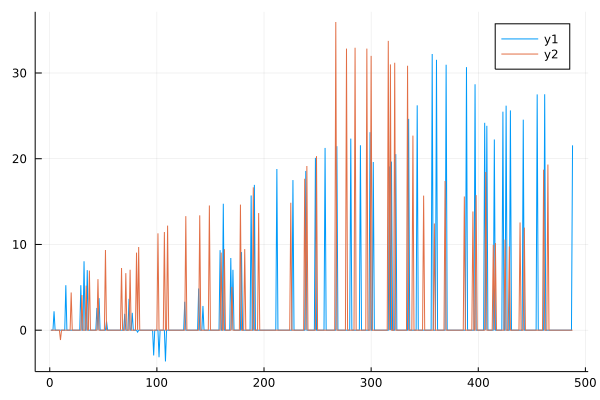

In [31]:
plot(PL1)
plot!(PL2)

In [32]:
gain1 = count(y->y>0,PL1)
loss1 = count(y->y<0,PL1)
gain2 = count(y->y>0,PL2)
loss2 = count(y->y<0,PL2)
@show gain1,loss1,gain2,loss2

(gain1, loss1, gain2, loss2) = (51, 4, 53, 1)


(51, 4, 53, 1)

In [33]:
function computeScore(PL)
    profit = count(y->y>0,PL)
    loss = count(y->y<0,PL)
    return profit / (profit+loss)
end
@show computeScore(PL1)
@show computeScore(PL2)

computeScore(PL1) = 0.9272727272727272
computeScore(PL2) = 0.9814814814814815


0.9814814814814815

In [34]:
n = length(PL1)

488

In [35]:
function accumulatePlot(PL)
    N = length(PL)
    acc = zeros(N)
    for i in 1:N
        if i == 1
            acc[i] = PL[i]
        else
            acc[i] = acc[i-1]+PL[i]
        end
    end
    return acc
end


accumulatePlot (generic function with 1 method)

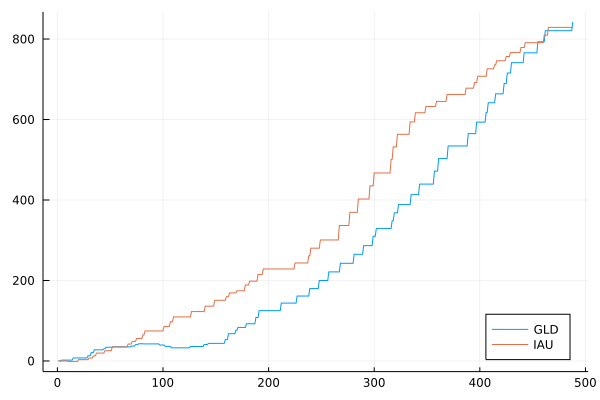

In [36]:
plot(accumulatePlot(PL1),label = tick1,legend=:bottomright)
plot!(accumulatePlot(PL2),label = tick2,legend=:bottomright)

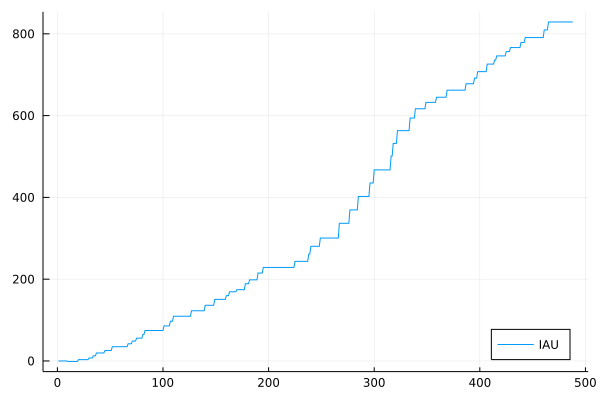

In [37]:
plot(accumulatePlot(PL2),label = tick2,legend=:bottomright)